In [19]:
!pip3 install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=9ab288c1084ab50565d83154335bad800fe59f3de53b8006f22a24862bca2d89
  Stored in directory: /home/behnamnia/.cache/pip/wheels/90/1d/93/c863ee832230df5cfc25ca497b3e88e0ee3ea9e44adc46ac62
Successfully built wget


In [42]:
!pip3 install grad-cam

     |████████████████████████████████| 7.8 MB 6.0 MB/s            �█████████████████████████▌    | 6.7 MB 6.0 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=e1d5e4a42de08624e424f71e628b08c74d7321a0c439af56feb5164d3e69c2b0
  Stored in directory: /home/behnamnia/.cache/pip/wheels/7d/93/fd/97ae473b61d31f60a8a7ba625c6ede11ab00d63156fc47408c
Successfully built grad-cam


In [99]:
!pip3 install einops

  Using cached einops-0.4.1-py3-none-any.whl (28 kB)


In [ ]:
#!unzip Data/COCO17/train2017.zip.1 -d Data/COCO17/

In [1]:
import json
from pycocotools.coco import COCO
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms
import wget
import os
import timm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import einops
import torch
import torch.nn as nn
from transformers import GPT2Config, GPT2LMHeadModel
from tokenizers import ByteLevelBPETokenizer
from torch.utils.data import DataLoader
from tqdm import tqdm
import re
from nltk.stem.wordnet import WordNetLemmatizer
import math
from time import time
from dataloader import COCODataset
from torch.multiprocessing import set_start_method

In [2]:
import nltk

# Prepare data

In [3]:
!nvidia-smi

Thu Dec 15 05:13:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:17:00.0 Off |                  N/A |
|  0%   32C    P8    12W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:65:00.0 Off |                  N/A |
|  0%   33C    P8    19W / 250W |     10MiB / 11175MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [26]:
MAX_SEQ_LENGTH = 32
BATCH_SIZE = 64
EOS_ID = 2
BOS_ID = 0

In [27]:
captions = json.load(open('Data/COCO17/cap_dict.json', 'r'))

In [28]:
len(captions)

118287

In [29]:
small_idx = set(sorted(list(captions.keys()))[:1000])

In [30]:
small_captions = {int(k):v for k, v in captions.items() if k in small_idx}

In [31]:
orig = COCO('Data/COCO17/captions_train2017.json')

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


In [32]:
images = orig.loadImgs(sorted(list(small_captions.keys())))

In [33]:
images[0]

{'license': 2,
 'file_name': '000000001006.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000001006.jpg',
 'height': 640,
 'width': 427,
 'date_captured': '2013-11-24 06:05:29',
 'flickr_url': 'http://farm8.staticflickr.com/7016/6665190797_9f64902255_z.jpg',
 'id': 1006}

In [34]:
# for item in images:
#     if not os.path.exists(os.path.join('Data/COCO17/images/', item['file_name'])):
#         wget.download(item['coco_url'], out='Data/COCO17/images/')
#         print(f'image {item["file_name"]} downloaded.')

In [35]:
# class COCODataset:
#     def __init__(self, cap_dict, image_info, image_path):
#         self.cap_dict = cap_dict
#         self.index = sorted(list(self.cap_dict.keys()))
#         self.index_set = set(self.index)
#         self.image_id2name = dict()
#         for item in image_info:
#             if item['id'] in self.index_set:
#                 self.image_id2name[item['id']] = item['file_name']
#         self.image_files = [os.path.join(image_path, self.image_id2name[item]) for item in self.index]
#         self.transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize(mean = [0.485, 0.456, 0.406], 
#                                  std = [0.229, 0.224, 0.225])
#         ])
#     def __getitem__(self, idx):
#         image = Image.open(self.image_files[idx]).convert('RGB')
#         captions = self.cap_dict[self.index[idx]]
#         return image, captions
    
#     def __len__(self):
#         return len(self.index)

In [36]:
dataset = COCODataset(small_captions, images, 'Data/COCO17/train2017/')

In [37]:
# for i in range(len(dataset)):
#     image, captions = dataset[i]

# Image feature extractor

In [38]:
device = 'cuda:0'

In [39]:
grid_size = [64, 64]

In [40]:
m = timm.create_model('efficientnet_b0', pretrained=True).to(device)
_ = m.eval()
_ = m.to(device)

In [41]:
cam = GradCAM(model=m, target_layers=[m.blocks[6][-1]], use_cuda=True)

In [42]:
# def select_patches(image, device):
#     image_array = np.array(image)
#     h, w, _ = image_array.shape
#     W = ((w + grid_size[0] - 1) // grid_size[0]) * grid_size[0] 
#     H = ((h + grid_size[1] - 1) // grid_size[1]) * grid_size[1]
#     image_array = np.pad(image_array, [((H-h)//2, (H-h)-(H-h)//2), ((W-w)//2, (W-w)-(W-w)//2), (0, 0)], mode='linear_ramp')
#     image = Image.fromarray(image_array)
#     res = cam(input_tensor=dataset.transform(image).unsqueeze(0).to(device), targets=None)
#     res = res.squeeze()
#     image_grids = einops.rearrange(image_array, '(N h) (M w) C -> N M h w C', h=grid_size[1], w=grid_size[0])
#     res_grids = einops.rearrange(res, '(N h) (M w) -> N M h w', h=grid_size[1], w=grid_size[0])
#     u = np.mean(res_grids, axis=(-1, -2))
#     u /= np.sum(u)
#     choices = np.random.choice(range(u.size), p = u.flatten(), size = 5, replace=False)
#     x, y = choices // u.shape[1], choices % u.shape[1]
#     candidate_grids = image_grids[x, y, :, :]
#     candidate_grids = candidate_grids / 255
#     candidate_grids = (candidate_grids - np.array([[[[0.485, 0.456, 0.406]]]])) / np.array([[[[0.229, 0.224, 0.225]]]])
#     m_input = einops.rearrange(torch.tensor(candidate_grids), 'N H W C -> N C H W').float()
#     return m_input

In [43]:
dataset.cam = cam
dataset.device = device

In [44]:
# u, v = 1000, 1000
# u2, v2 = 100, 100
# for img, cap in dataset:
#     print(img.shape)
    # u, v = min(u, img.height), min(v, img.width)
    # u2, v2 = max(u2, img.height), max(v2, img.width)
# print(u, v)
# print(u2, v2)

In [45]:
# now = time()
# for i in range(100):
#     image, caption = dataset[0]
#     res = cam(input_tensor=image.to(device).unsqueeze(0), targets=None)
# print((time() - now)/100)

In [46]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=8, collate_fn=dataset.collate_fn, shuffle=True)

In [52]:
now = time()
c = 0
for item in dataloader:
    x = dataset.patch_batch(*item)
    c += 1
    print(x['patched_images'].shape)
    if c >= 10:
        break
print((time() - now) / (BATCH_SIZE * 10))

torch.Size([64, 5, 3, 64, 64])
torch.Size([64, 5, 3, 64, 64])
torch.Size([64, 5, 3, 64, 64])
torch.Size([64, 5, 3, 64, 64])
torch.Size([64, 5, 3, 64, 64])
torch.Size([64, 5, 3, 64, 64])
torch.Size([64, 5, 3, 64, 64])
torch.Size([64, 5, 3, 64, 64])
torch.Size([64, 5, 3, 64, 64])
torch.Size([64, 5, 3, 64, 64])
0.008733260631561279


In [50]:
0.008 * 118000 / 60

15.733333333333333

In [26]:
image, caption = dataset[0]
image_array = np.array(image)
h, w, _ = image_array.shape
W = ((w + grid_size[0] - 1) // grid_size[0]) * grid_size[0] 
H = ((h + grid_size[1] - 1) // grid_size[1]) * grid_size[1]
image_array = np.pad(image_array, [((H-h)//2, (H-h)-(H-h)//2), ((W-w)//2, (W-w)-(W-w)//2), (0, 0)], mode='linear_ramp')
image = Image.fromarray(image_array)
res = cam(input_tensor=dataset.transform(image).unsqueeze(0), targets=None)

TypeError: Cannot handle this data type: (1, 1, 448), <f4

In [ ]:
res = res.squeeze()

In [ ]:
visualization = show_cam_on_image(image_array / 255, res, use_rgb=True)

In [35]:
visualization.shape, res.shape

((640, 448, 3), (640, 448))

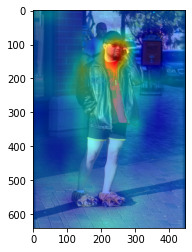

In [36]:
plt.imshow(visualization)

In [37]:
np.max(res), np.min(res)

(0.9999999, 0.0)

In [38]:
image_grids = einops.rearrange(image_array, '(N h) (M w) C -> N M h w C', h=grid_size[1], w=grid_size[0])

In [39]:
image_grids.shape

(10, 7, 64, 64, 3)

In [40]:
res_grids = einops.rearrange(res, '(N h) (M w) -> N M h w', h=grid_size[1], w=grid_size[0])

In [41]:
u = np.mean(res_grids, axis=(-1, -2))
u /= np.sum(u)

In [42]:
u

array([[0.01533185, 0.01238779, 0.01153142, 0.01284688, 0.01180775,
        0.01061249, 0.01195522],
       [0.01263361, 0.01191647, 0.01365117, 0.02952805, 0.02055638,
        0.0018976 , 0.01046598],
       [0.01318472, 0.01461934, 0.02195866, 0.0343519 , 0.02009482,
        0.00610576, 0.0116721 ],
       [0.01483528, 0.01752818, 0.02228061, 0.02333656, 0.02053159,
        0.01571411, 0.01461631],
       [0.01078354, 0.01395514, 0.02048735, 0.02119528, 0.01784586,
        0.01105178, 0.01113321],
       [0.01089591, 0.01267491, 0.01857121, 0.0157383 , 0.01718051,
        0.00868966, 0.01070869],
       [0.01127425, 0.01101526, 0.01555518, 0.01330266, 0.01371009,
        0.01027882, 0.01251331],
       [0.01315639, 0.0141622 , 0.01445113, 0.01325878, 0.01302586,
        0.01180685, 0.01286014],
       [0.01243255, 0.01191365, 0.01237496, 0.0089326 , 0.01406723,
        0.01286083, 0.01164803],
       [0.01210781, 0.01190427, 0.01468889, 0.01630871, 0.01585886,
        0.01329209, 0.0

In [43]:
choices = np.random.choice(range(u.size), p = u.flatten(), size = 5, replace=False)

In [44]:
x, y = choices // u.shape[1], choices % u.shape[1]

In [45]:
candidate_grids = image_grids[x, y, :, :]

In [46]:
candidate_grids = candidate_grids / 255
candidate_grids = (candidate_grids - np.array([[[[0.485, 0.456, 0.406]]]])) / np.array([[[[0.229, 0.224, 0.225]]]])
m_input = einops.rearrange(torch.tensor(candidate_grids), 'N H W C -> N C H W').float()

In [47]:
with torch.no_grad():
    features = torch.mean(m.forward_features(m_input.to(device)), dim=(-1, -2))

In [48]:
features.shape

torch.Size([5, 1280])

# Prepare tokenizer 

In [49]:
tokenizer = ByteLevelBPETokenizer()
tokenizer.train(files='Data/COCO17/all_text.txt', vocab_size=10_000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

In [50]:
def caption2batch(captions, max_seq_length=MAX_SEQ_LENGTH):
    pad_id = tokenizer.encode('<pad>').ids[0]
    all_in = []
    all_out = []
    attention_mask = []
    max_tokens = 0
    for caption in captions:
        x_in = tokenizer.encode('<s>' + caption).ids
        x_out = tokenizer.encode(caption + '</s>').ids
        if len(x_in) > max_seq_length:
            x_in = [x_in[0]] + x_in[1:max_seq_length]
            x_out = x_out[:max_seq_length-1] + [x_out[-1]]
        all_in.append(x_in)
        all_out.append(x_out)
        max_tokens = max(max_tokens, len(x_in))
    for i in range(len(all_in)):
        attention_mask.append([1] * len(all_in[i]) + [0] * (max_tokens - len(all_in[i])))
        all_in[i] += [pad_id] * (max_tokens - len(all_in[i]))
        all_out[i] += [pad_id] * (max_tokens - len(all_out[i]))
    return torch.tensor(all_in, dtype=torch.int64), torch.tensor(all_out, dtype=torch.int64), torch.tensor(attention_mask, dtype=torch.int64)

In [51]:
all_in, all_out, attn = caption2batch(captions)

In [52]:
# def collate_fn(data):
#     images, captions = zip(*data)
#     patched_images = []
#     selected_captions = []
#     for i, image in enumerate(images):
#         patched_images.append(select_patches(image, device))
#         u = np.random.choice(range(len(captions[i])))
#         selected_captions.append(captions[i][u])
#     captions_in, captions_out, attention_mask = caption2batch(selected_captions)
#     patched_images = torch.stack(patched_images)
#     return patched_images, captions_in, captions_out, attention_mask, selected_captions, captions

In [53]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=0, collate_fn=collate_fn, shuffle=True)

In [54]:
for img, c_in, c_out, attn, cap_name in dataloader:
    N, T, C, H, W = img.shape
    img = img.to(device)
    with torch.no_grad():
        features = torch.mean(m.forward_features(einops.rearrange(img, 'N T C H W -> (N T) C H W')), dim=(-1, -2))
    features = einops.rearrange(features, '(N T) F -> N T F', T = T)
    print(c_in)
    print(c_out)
    print(attn)
    break

tensor([[   0,   69,  627,  277,  261,  691,  488,  261, 1030, 8016,  280,  261,
          469,    1,    1,    1,    1],
        [   0,   69,  579,  280,  261,  524,  368,  297,  261,  651,  292,  579,
         1130, 3883,    1,    1,    1],
        [   0,   69,  314, 1926,  297, 8929,  984,  638,  261, 3593,    1,    1,
            1,    1,    1,    1,    1],
        [   0,   69, 2545,  289,  978, 2772, 1696,  279,  876, 3675,    1,    1,
            1,    1,    1,    1,    1],
        [   0,  380,  910,  393,  338,  356,  280,  284,  485,    1,    1,    1,
            1,    1,    1,    1,    1],
        [   0,  720, 1441,  524,  289,  579, 1196,  654,  292,  808,    1,    1,
            1,    1,    1,    1,    1],
        [   0,   69,  709,  469,  289, 2050, 1092,  292,  261,  418, 1733, 1251,
         1113,    1,    1,    1,    1],
        [   0,   69,  471,  438,  635,  277,  261,  506, 1950,  774,  284, 1030,
            1,    1,    1,    1,    1],
        [   0, 3191,  292, 2270,

# Caption Reward Class

In [55]:
dictionary = json.load(open('Data/COCO17/dictionary.json', 'r'))

In [60]:
cap_dict = json.load(open('Data/COCO17/cap_dict.json', 'r'))

In [69]:
dictionary = {int(k):v for k, v in dictionary.items()}
cap_dict = {int(k): v for k, v in cap_dict.items()}

In [120]:
class CaptionReward:
    def __init__(self, dictionary, N):
        self.N = N
        self.dictionary = dictionary
        
    def cos_similarity(self, d1, d2):
        score = 0
        total1 = 0
        total2 = 0
        for k, v in d1.items():
            if k in d2:
                score += v * d2[k]
            total1 += v ** 2
        for k, v in d2.items():
            total2 += v ** 2
        return (score + 1e-8) / math.sqrt(total1 * total2 + 1e-8)
    
    def clean_text(self, text):
        text = re.sub('[.,;!?]', ' ', text)
        text = re.sub('[ ][ ]+', ' ', text).strip()
        text = text.lower()
        return text
    
    def tf_idf(self, text, order):
        text = self.clean_text(text)
        tf = dict()
        result = dict()
        count = 0
        tokens = [lemmatizer.lemmatize(item) for item in text.split(' ')]
        if len(tokens) < order:
            return {}
        for i in range(len(tokens) - order + 1):
            token = ' '.join(tokens[i:i+order])
            if token not in tf:
                tf[token] = 0
            tf[token] += 1
            count += 1
        for token, tf_value in tf.items():
            if token in self.dictionary[order]:
                df = self.dictionary[order][token]['df']
            else:
                df = 0
            result[token] = (tf[token] / count) * math.log((self.N + 1) / (df + 1))
        return result
    
    def cider(self, refs, c):
        final_score = 0
        for order in [1, 2, 3, 4]:
            ref_scores = []
            for ref in refs:
                ref_scores.append(self.tf_idf(ref, order=order))
            c_score = self.tf_idf(c, order=order)
            score = 0
            for ref_score in ref_scores:
                score += self.cos_similarity(c_score, ref_score)
            score /= len(refs)
            final_score += score
        return final_score / 4

In [121]:
lemmatizer = WordNetLemmatizer()

In [122]:
cap_reward = CaptionReward(dictionary, len(cap_dict))

In [127]:
cap_reward.cider(caption, 'a man with a book')

0.010004503114036912

In [134]:
tokenizer.decode([10, 5, 6, 2, 5])

'&!"!'

In [140]:
def id2string(cap, tokenizer, batch=False):
    if batch:
        out = []
        for caption in cap:
            out.append(id2string(caption, tokenizer))
        return out
    else:
        filtered_cap = []
        for item in cap:
            if item == BOS_ID:
                filtered_cap = []
            elif item == EOS_ID:
                break
            else:
                filtered_cap.append(item)
        return tokenizer.decode(filtered_cap)

In [141]:
id2string([10, 5, 6, 2, 5], tokenizer)

'&!"'

# Prepare value and policy networks

In [67]:
config = GPT2Config(vocab_size=10_000, n_positions=32, n_embd=256, n_layer=8, n_head=4, eos_token_id=2, bos_token_id=0, add_cross_attention=True)
policy_backbone = GPT2LMHeadModel(config).to(device)
value_backbone = GPT2LMHeadModel(config).to(device)
#fc_layer = nn.Linear(1280, 256).to(device)

# Train Policy Network

In [68]:
class PolicyNetwork(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.fc = nn.Linear(1280, 256)
    
    def forward(self, cap_in, attn, features):
        features = self.fc(features)
        return self.backbone(input_ids=cap_in, attention_mask=attn, encoder_hidden_states=features)

    def generate(self, features):
        features = self.fc(features)
        return self.backbone.generate(encoder_hidden_states=features)

In [69]:
policy_network = PolicyNetwork(backbone=policy_backbone).to(device)

In [70]:
criterion = nn.CrossEntropyLoss(reduction='none').to(device)
optimizer = torch.optim.Adam(policy_network.parameters(), lr=0.0001)

In [72]:
bestLoss = 1.9
n_epochs = 20
for epoch in range(n_epochs):
    total_loss = 0
    total_accuracy = 0
    count = 0
    for img, cap_in, cap_out, attn, _, _ in tqdm(dataloader):
        N, T, C, H, W = img.shape
        img = img.to(device)
        cap_in = cap_in.to(device)
        cap_out = cap_out.to(device)
        attn = attn.to(device)
        with torch.no_grad():
            features = torch.mean(m.forward_features(einops.rearrange(img, 'N T C H W -> (N T) C H W')), dim=(-1, -2))
        features = einops.rearrange(features, '(N T) F -> N T F', T = T)
        output = policy_network(cap_in, attn, features)
        out = einops.rearrange(output.logits, 'N T P -> N P T')
        loss = torch.mean(torch.sum(criterion(out, cap_out) * attn, dim=-1) / torch.sum(attn, dim=-1))
        total_loss += loss.item() * N
        count += N
        total_accuracy += torch.mean(torch.sum((torch.argmax(out, dim=1) == cap_out) * attn, dim=-1) / torch.sum(attn, dim=-1)).item() * N    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    total_loss /= count
    total_accuracy /= count
    print("Epoch:", epoch + 1, "loss:", total_loss, "Acc:", total_accuracy * 100)
    if total_loss < bestLoss:
        bestLoss = total_loss
        torch.save(policy_network.state_dict(), "Models/policy_network.pt")
        print('----Best model saved.')
        

100%|██████████| 32/32 [01:09<00:00,  2.16s/it]


Epoch: 1 loss: 7.901507171630859 Acc: 20.446816349029543


100%|██████████| 32/32 [01:09<00:00,  2.17s/it]


Epoch: 2 loss: 6.911219955444336 Acc: 23.18309087753296


100%|██████████| 32/32 [01:09<00:00,  2.18s/it]


Epoch: 3 loss: 6.151190818786621 Acc: 24.546228885650635


100%|██████████| 32/32 [01:09<00:00,  2.19s/it]


Epoch: 4 loss: 5.605170112609863 Acc: 25.819731450080873


100%|██████████| 32/32 [01:09<00:00,  2.19s/it]


Epoch: 5 loss: 5.261718845367431 Acc: 27.355948925018307


100%|██████████| 32/32 [01:10<00:00,  2.19s/it]


Epoch: 6 loss: 5.005664066314697 Acc: 28.988360810279843


100%|██████████| 32/32 [01:10<00:00,  2.19s/it]


Epoch: 7 loss: 4.856216567993164 Acc: 30.08176064491272


100%|██████████| 32/32 [01:10<00:00,  2.19s/it]


Epoch: 8 loss: 4.8061171035766606 Acc: 30.31256551742554


100%|██████████| 32/32 [01:10<00:00,  2.19s/it]


Epoch: 9 loss: 4.625090408325195 Acc: 31.98979570865631


100%|██████████| 32/32 [01:10<00:00,  2.20s/it]


Epoch: 10 loss: 4.57916032409668 Acc: 31.71397285461426


100%|██████████| 32/32 [01:10<00:00,  2.20s/it]


Epoch: 11 loss: 4.482409042358398 Acc: 32.346877336502075


100%|██████████| 32/32 [01:10<00:00,  2.20s/it]


Epoch: 12 loss: 4.426988723754882 Acc: 32.796797037124634


100%|██████████| 32/32 [01:10<00:00,  2.20s/it]


Epoch: 13 loss: 4.358503448486328 Acc: 33.056767272949216


100%|██████████| 32/32 [01:10<00:00,  2.20s/it]


Epoch: 14 loss: 4.263893898010254 Acc: 34.30557706356049


100%|██████████| 32/32 [01:10<00:00,  2.21s/it]


Epoch: 15 loss: 4.2521094131469725 Acc: 33.88499487638473


100%|██████████| 32/32 [01:10<00:00,  2.20s/it]


Epoch: 16 loss: 4.197015609741211 Acc: 34.86425590515137


100%|██████████| 32/32 [01:10<00:00,  2.20s/it]


Epoch: 17 loss: 4.106218744277954 Acc: 35.298906373977665


100%|██████████| 32/32 [01:10<00:00,  2.21s/it]


Epoch: 18 loss: 4.107451377868652 Acc: 35.148528480529784


100%|██████████| 32/32 [01:10<00:00,  2.20s/it]


Epoch: 19 loss: 4.046264350891113 Acc: 35.89055762290955


100%|██████████| 32/32 [01:10<00:00,  2.20s/it]

Epoch: 20 loss: 3.980098171234131 Acc: 36.290602684020996


# Train Value Network


In [107]:
class ValueNetwork(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.fc = nn.Linear(1280, 256)
    
    def forward(self, cap_in, attn, features):
        features = self.fc(features)
        hidden_states = self.backbone(input_ids=cap_in, attention_mask=attn, 
                                      encoder_hidden_states=features, output_hidden_states=True).hidden_states
        print(hidden_states[-1].shape)

In [108]:
value_network = ValueNetwork(backbone=value_backbone).to(device)

In [109]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(value_network.parameters(), lr=0.0001)

In [110]:
def get_random_level(attn):
    rand_ids = (torch.rand(len(cap_in), device=device) * torch.sum(attn, dim=-1) + 0.99).long()
    new_attn = torch.ones(attn.shape, dtype=torch.int64)
    for i in range(len(rand_ids)):
        new_attn[i][:rand_ids[i]] = 1
    return new_attn.to(device)

In [114]:
torch.ones(5) == 0.4

tensor([False, False, False, False, False])

In [ ]:
def GenerateCaptionsWithBeamSearch(model, cap_in, features, beamSize=5, eos_id=EOS_ID):
    gen_caps = torch.tensor(cap_in[:, 0:1], device=device).long()
    N = len(cap_in)
    candidates = [(gen_caps, torch.ones(N, 1, dtype=torch.int64).to(device), 0)]
    for t in range(MAX_SEQ_LENGTH-1):
        next_candidates = []
        for c in range(len(candidates)):
            output = model(candidates[c][0], candidates[c][1], features).logits
            probs, words = torch.topk(output[:, -1:, :], beamSize)
            for i in range(beamSize):
                cap_already_ended = torch.sum(eos_id == candidates[c][1], dim=-1).bool().float()
                attn = torch.cat((candidates[c][1], words[:, :, i] == eos_id), axis=1) 
                cap = torch.cat((candidates[c][0], words[:, :, i]), axis=1)
                score = candidates[c][2] - torch.log(probs[0, 0, i]).item() * (1 - cap_already_ended)
                next_candidates.append((cap, score))
        ordered_candidates = sorted(next_candidates, key=lambda tup:tup[2])
        candidates = ordered_candidates[:beamSize]
    captions = [item[0] for item in candidates]
    return captions


In [ ]:
bestLoss = 10000
n_epochs = 20
for epoch in range(n_epochs):
    total_loss = 0
    total_accuracy = 0
    count = 0
    for img, cap_in, cap_out, attn, cap_name in tqdm(dataloader):
        N, T, C, H, W = img.shape
        img = img.to(device)
        cap_in = cap_in.to(device)
        cap_out = cap_out.to(device)
        attn = attn.to(device)
        with torch.no_grad():
            features = torch.mean(m.forward_features(einops.rearrange(img, 'N T C H W -> (N T) C H W')), dim=(-1, -2))
        # Generate captions using the policy network
        captions = GenerateCaptionsWithBeamSearch(policy_network, cap_in, features)
    
        # Compute the reward of the generated caption using reward network
        rewards = cap_reward.cider(cap_in, cap_out)

        # Compute the value of a random state in the generation process
        values = valueNetwork(captions[:, :random.randint(1, MAX_SEQ_LENGTH)], attn[:, :random.randint(1, MAX_SEQ_LENGTH)], features)
    
    # Compute the loss for the value and the reward
    loss = criterion(values, rewards)
    
    if loss.item() < bestLoss:
        bestLoss = loss.item()
        torch.save(valueNetwork.state_dict(), "valueNetwork.pt")
        print("epoch:", epoch, "loss:", loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    valueNetwork.valrnn.hidden_cell[0].detach_()
    valueNetwork.valrnn.hidden_cell[1].detach_()
    rewardNet.rewrnn.hidden_cell.detach_()


In [111]:
bestLoss = 1.9
n_epochs = 1
for epoch in range(n_epochs):
    total_loss = 0
    total_accuracy = 0
    count = 0
    for img, cap_in, cap_out, attn, cap_name in tqdm(dataloader):
        N, T, C, H, W = img.shape
        img = img.to(device)
        cap_in = cap_in.to(device)
        cap_out = cap_out.to(device)
        attn = attn.to(device)
        with torch.no_grad():
            features = torch.mean(m.forward_features(einops.rearrange(img, 'N T C H W -> (N T) C H W')), dim=(-1, -2))
        features = einops.rearrange(features, '(N T) F -> N T F', T = T)
        for t in range(T):
            step_features = features[:, :(t + 1)]
            attn = get_random_level(attn)
            output = value_network(cap_in, attn, features)
            break
#         out = einops.rearrange(output.logits, 'N T P -> N P T')
#         loss = torch.mean(torch.sum(criterion(out, cap_out) * attn, dim=-1) / torch.sum(attn, dim=-1))
#         total_loss += loss.item() * N
#         count += N
#         total_accuracy += torch.mean(torch.sum((torch.argmax(out, dim=1) == cap_out) * attn, dim=-1) / torch.sum(attn, dim=-1)).item() * N    
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     total_loss /= count
#     total_accuracy /= count
#     print("Epoch:", epoch + 1, "loss:", total_loss, "Acc:", total_accuracy * 100)
#     if total_loss < bestLoss:
#         bestLoss = total_loss
#         torch.save(policy_network.state_dict(), "Models/policy_network.pt")
#         print('----Best model saved.')
        

  3%|▎         | 1/32 [00:02<01:10,  2.27s/it]

torch.Size([32, 19, 256])


  6%|▋         | 2/32 [00:04<01:08,  2.27s/it]

torch.Size([32, 22, 256])


  6%|▋         | 2/32 [00:05<01:20,  2.69s/it]


KeyboardInterrupt: 